# Hands-on Day 3

## You'll learn

### ML methods

- Deep NN with keras

# Initial setup 

- read in parquet file
- create x,y vectors from panda dataframe

In [2]:
%reload_ext custom_functions
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

In [3]:
#inputFile = 'file:///home/jovyan/Higgs100k.parquet'
#inputFile = 'file:///home/jovyan/Higgs1M.parquet'
inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = pd.read_parquet(inputFile)

CPU times: user 6.99 s, sys: 13 s, total: 20 s
Wall time: 1.08 s


In [4]:
# The first column is the target variable
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

len(x)

10000000

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
#sanity check

print(len(x_train)+len(x_test))
print(len(y_train)+len(y_test))

10000000
10000000


# ML Models: Sequential

We will use Keras with Tensorflow as backend (supports multi-core and GPUs)

In [7]:
#ignore warnings from Tensorflow
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=DeprecationWarning)
import tensorflow as tf
#if type(tf.contrib) != type(tf): tf.contrib._warning = None
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#import Keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(1337)  # for reproducibility

## Exercise 1

- documentation: https://keras.io/getting-started/sequential-model-guide/
- Build (compile) a Keras Sequential model (call it *model*)
  - 1 hidden layer  with 100 neurons, activation ReLU (put in the correct input_shape!)
  - 1 ouput layer with activation sigmoid
  - use Adam optimiser
  - use binary_crossentropy loss
  - use accuracy metrics 

In [8]:
# create the model
model = Sequential()

#baseline, 13m with 1M events, acc 74%, AUC 81
model.add(Dense(100, activation='relu', input_shape=(28,)))
model.add(Dense(1, activation='sigmoid'))
opt = Adam()

# Compile model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [9]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [10]:
# set batch size according to size of the input sample!!!
# start training with reasonable numer of epoch

%time history = model.fit(x, y, batch_size=512, epochs=10, validation_data=(x_test, y_test), callbacks=[es]) #, verbose=0)

Epoch 1/10
19532/19532 [==============================] - 86s 4ms/step - loss: 0.5743 - accuracy: 0.6984 - val_loss: 0.5483 - val_accuracy: 0.7209
Epoch 2/10
19532/19532 [==============================] - 82s 4ms/step - loss: 0.5413 - accuracy: 0.7246 - val_loss: 0.5346 - val_accuracy: 0.7289
Epoch 3/10
19532/19532 [==============================] - 82s 4ms/step - loss: 0.5316 - accuracy: 0.7310 - val_loss: 0.5276 - val_accuracy: 0.7341
Epoch 4/10
19532/19532 [==============================] - 83s 4ms/step - loss: 0.5272 - accuracy: 0.7340 - val_loss: 0.5252 - val_accuracy: 0.7346
Epoch 5/10
19532/19532 [==============================] - 84s 4ms/step - loss: 0.5241 - accuracy: 0.7358 - val_loss: 0.5207 - val_accuracy: 0.7376
Epoch 6/10
19532/19532 [==============================] - 83s 4ms/step - loss: 0.5221 - accuracy: 0.7370 - val_loss: 0.5223 - val_accuracy: 0.7376
Epoch 7/10
19532/19532 [==============================] - 84s 4ms/step - loss: 0.5208 - accuracy: 0.7378 - val_loss: 0

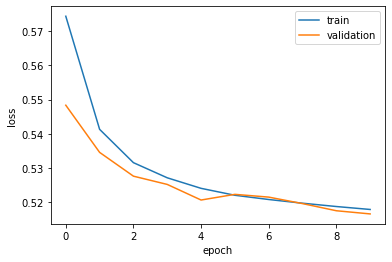

In [11]:
plotVsEpoch(history, 'loss')

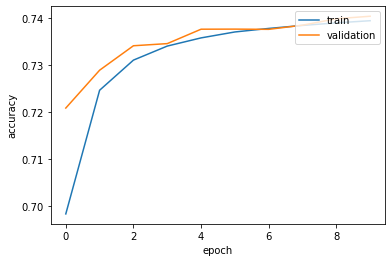

In [12]:
plotVsEpoch(history, 'accuracy')

In [13]:
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 10, 'steps': 19532}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2900      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


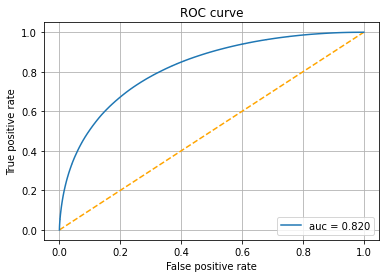

In [15]:
# apply model to get predictions on test set
y_pred = model.predict(x_test)

#draw ROC
drawROC2(y_test, y_pred)

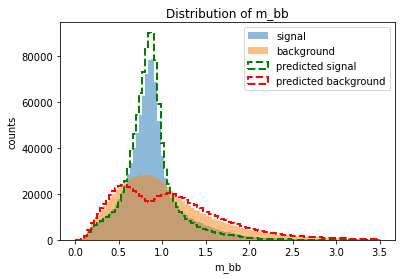

In [16]:
#plot signal vs background with prediction
variable = 'm_bb'

# Get the predicted probabilities for the positive class
y_pred_prob = model.predict(x_test).ravel()  # Use .ravel() to flatten to a 1D array

plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred_prob)

# Hyperparameters optimisation

- you can use [keras_tuner](https://keras.io/keras_tuner/) for hyperparameter optimisation


In [17]:
import keras_tuner as kt

In [18]:
# you may need to install it with
#!pip install --user keras-tuner

## Exercise 2

- play with the model parameters and see if you can improve the performances 
- try to increase the number of epochs for training, is the model improving?
- how is training time affected by the number of parameters?
- how is signal versus background separation affected (check different variables)

In [19]:
# read in input parquet file
#inputFile = 'file:///home/jovyan/Higgs100k.parquet'
inputFile = 'file:///home/jovyan/Higgs1M.parquet'

%time df = pd.read_parquet(inputFile)

#create train/test set
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
len(y)

CPU times: user 964 ms, sys: 1.22 s, total: 2.18 s
Wall time: 152 ms


999999

In [20]:
import keras_tuner as kt

# Define the model-building function
def build_model(hp):
    model = Sequential()

    # Tune the number of units in the hidden layers
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=256, step=32), activation='relu', input_dim=x_train.shape[1]))
    
    # Add a dropout layer - not a good idea because it is not used for inference
    # unwanted regularization effect that makes better accuracy on test than on train
    #model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    # Tune the learning rate for the optimizer
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, 
                  max_value=1e-2, sampling='LOG')), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model, 
    objective='val_accuracy',  # Optimization target
    max_trials=5,               # Number of models to try
    executions_per_trial=3,     # Number of executions for each trial
    directory='keras',         # Directory to store the results
    project_name='bigDataML'
)

# Run the hyperparameter search
%time tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Get the best model and parameters
best_model = tuner.get_best_models(num_models=1)[0]
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"Units: {best_params['units']}")
print(f"Dropout: {best_params['dropout']}")
print(f"Learning Rate: {best_params['learning_rate']}")

# Evaluate the best model
test_loss, test_acc = best_model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Reloading Tuner from keras/bigDataML/tuner0.json
CPU times: user 451 µs, sys: 296 µs, total: 747 µs
Wall time: 797 µs
Best Hyperparameters:
Units: 32
Dropout: 0.30000000000000004
Learning Rate: 0.0022174218292679996
6250/6250 [==============================] - 7s 1ms/step - loss: 0.6046 - accuracy: 0.6808
Test Loss: 0.6046
Test Accuracy: 0.6808


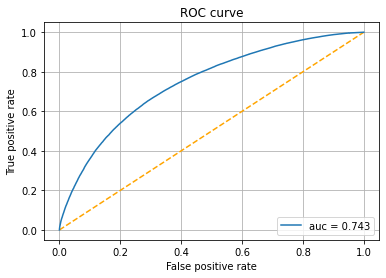

In [21]:
# apply model to get predictions on test set
y_pred = best_model.predict(x_test)

#draw ROC
drawROC2(y_test, y_pred)

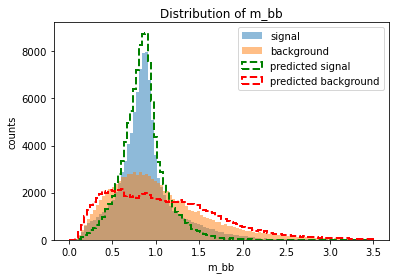

In [22]:
#plot signal vs background with prediction
variable = 'm_bb'

# Get the predicted probabilities for the positive class
y_pred_prob = best_model.predict(x_test).ravel()  # Use .ravel() to flatten to a 1D array

plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred_prob)

In [23]:
# Print a summary of the model architecture
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                928       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


## Train best model on 10M events

In [24]:
# read in input parquet file
input_file = "Higgs10M.parquet"
%time df = pd.read_parquet(input_file)

#create train/test set
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
len(y)

CPU times: user 6.99 s, sys: 13 s, total: 20 s
Wall time: 759 ms


10000000

In [25]:
# Rebuild the model using these best hyperparameters
new_best_model = build_model(best_params)

# Compile the model with the same loss and metrics as used previously
new_best_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',   # or whichever loss you used
    metrics=['accuracy']
)

In [26]:
%%time
new_history = new_best_model.fit(x_train, y_train, batch_size=512, epochs=30, validation_data=(x_test, y_test), callbacks=[es]) #, verbose=0)

Epoch 1/30
15625/15625 [==============================] - 46s 3ms/step - loss: 0.5965 - accuracy: 0.6789 - val_loss: 0.5740 - val_accuracy: 0.6983
Epoch 2/30
15625/15625 [==============================] - 44s 3ms/step - loss: 0.5659 - accuracy: 0.7065 - val_loss: 0.5612 - val_accuracy: 0.7113
Epoch 3/30
15625/15625 [==============================] - 44s 3ms/step - loss: 0.5580 - accuracy: 0.7123 - val_loss: 0.5544 - val_accuracy: 0.7154
Epoch 4/30
15625/15625 [==============================] - 43s 3ms/step - loss: 0.5538 - accuracy: 0.7152 - val_loss: 0.5526 - val_accuracy: 0.7179
Epoch 5/30
15625/15625 [==============================] - 43s 3ms/step - loss: 0.5499 - accuracy: 0.7179 - val_loss: 0.5468 - val_accuracy: 0.7208
Epoch 6/30
15625/15625 [==============================] - 42s 3ms/step - loss: 0.5463 - accuracy: 0.7205 - val_loss: 0.5488 - val_accuracy: 0.7207
Epoch 7/30
15625/15625 [==============================] - 41s 3ms/step - loss: 0.5434 - accuracy: 0.7227 - val_loss: 0

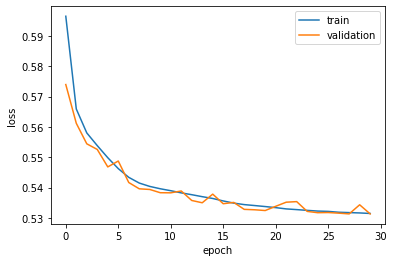

In [27]:
plotVsEpoch(new_history, 'loss')

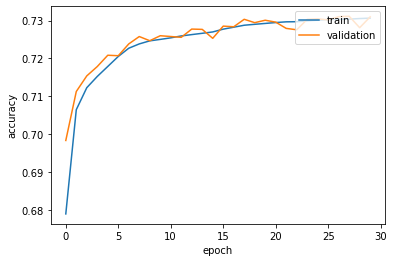

In [28]:
plotVsEpoch(new_history, 'accuracy')

In [29]:
print(new_history.params)
print(new_history.history.keys())

{'verbose': 1, 'epochs': 30, 'steps': 15625}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [30]:
# Evaluate the model on the test set
test_loss, test_accuracy = new_best_model.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

62500/62500 [==============================] - 94s 2ms/step - loss: 0.5313 - accuracy: 0.7310
Test Loss: 0.5313
Test Accuracy: 0.7310


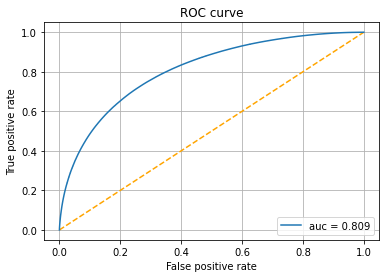

In [31]:
# apply model to get predictions on test set
y_pred = new_best_model.predict(x_test)

#draw ROC
drawROC2(y_test, y_pred)

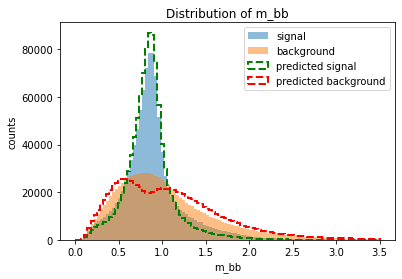

In [32]:
#plot signal vs background with prediction
variable = 'm_bb'

# Get the predicted probabilities for the positive class
y_pred_prob = new_best_model.predict(x_test).ravel()  # Use .ravel() to flatten to a 1D array

plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred_prob)